In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'DeepMicroC-master'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DeepMicroC-master


In [2]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap='YlOrRd', vmin =0, vmax=1)
    return

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 16

In [5]:
train_data = np.load('data/train_data.npz')

In [6]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [7]:
train = torch.tensor(train_data['train'], dtype=torch.float)
target = torch.tensor(train_data['target'], dtype=torch.float)

dataset = TensorDataset(train, target)

In [8]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
from models.deephic import Generator, Discriminator

try:
  
  netG = Generator(scale_factor=1, in_channel=1, resblock_num=5).to(device)
  netD = Discriminator(in_channel=1).to(device)
  netG.load_state_dict(torch.load('models/generator.pt',map_location=device))
  netD.load_state_dict(torch.load('models/discriminator.pt', map_location=device))
  print('loaded saved models')

except:
  print('new models')
  netG = Generator(scale_factor=1, in_channel=1, resblock_num=5).to(device)
  netD = Discriminator(in_channel=1).to(device)

loaded saved models


In [10]:
# loss function
from models.loss import GeneratorLoss, discriminator_loss
criterionG = GeneratorLoss().to(device)
criterionD = discriminator_loss

# optimizer
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

In [11]:
torch.cuda.empty_cache()

In [12]:
!nvidia-smi

Thu Jun  2 08:09:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    36W / 250W |   1011MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    images = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, target in loader_train:
            if len(x) != batch_size:
                print(len(x))
                continue

            D_solver.zero_grad()

            real_images = target.type(dtype)
            logits_real = D(real_images).type(dtype)

            z = x.type(dtype)
            fake_images = G(z).detach()
            logits_fake = D(fake_images)


            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward(retain_graph=False)
            D_solver.step()
            


            G_solver.zero_grad()
            fake_images = G(z)
            logits_fake = D(fake_images)

            g_error = generator_loss(logits_fake, fake_images, real_images)
            g_error.backward()

            
            G_solver.step()
            

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1

    return images

In [31]:
images = run_a_gan(
    D=netD,
    G=netG,
    D_solver=optimizerD,
    G_solver=optimizerG,
    discriminator_loss=criterionD,
    generator_loss=criterionG,
    loader_train=data_loader,
    batch_size=batch_size,
    num_epochs=3
)

Iter: 0, D: 0.2731, G:0.01182
Iter: 250, D: 0.162, G:0.01157
Iter: 500, D: 0.666, G:0.01543
Iter: 750, D: 0.4577, G:0.01036
Iter: 1000, D: 0.4018, G:0.01254
Iter: 1250, D: 0.1599, G:0.01113
Iter: 1500, D: 0.3866, G:0.01234
Iter: 1750, D: 0.2913, G:0.0126
Iter: 2000, D: 0.9051, G:0.01319


Iter: 0


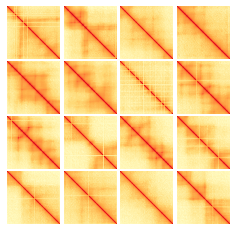


Iter: 250


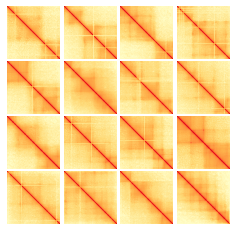


Iter: 500


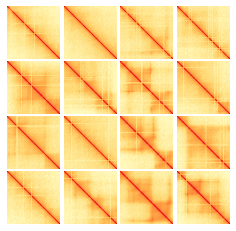


Iter: 750


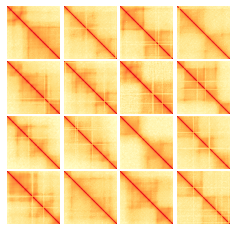


Iter: 1000


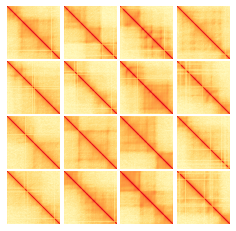


Iter: 1250


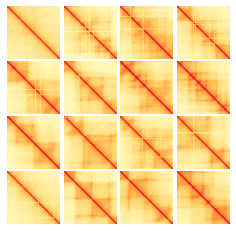


Iter: 1500


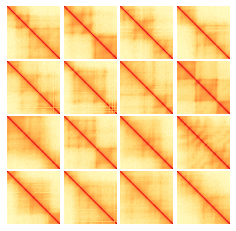


Iter: 1750


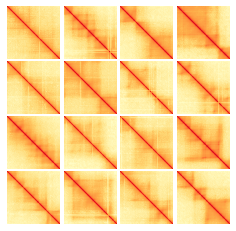


Iter: 2000


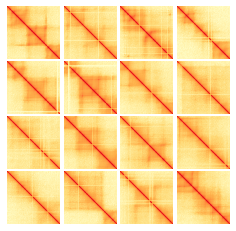

In [32]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

In [76]:
# torch.save(netG.state_dict(), 'models/generator.pt')
# torch.save(netD.state_dict(), 'models/discriminator.pt')

In [77]:
k = 2014
predicted_mats = netG(train[k:k+1].to(device)).data.cpu().numpy()

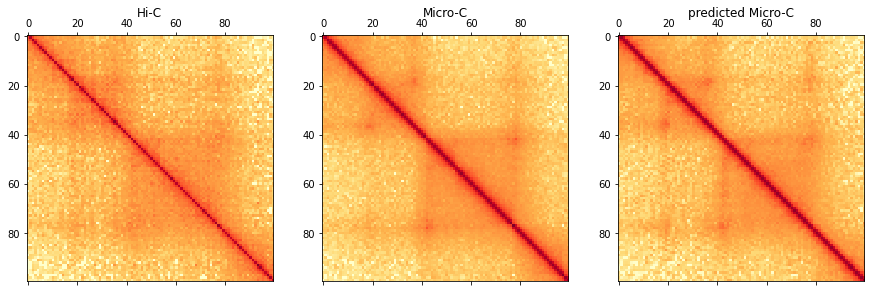

In [78]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1,3,1)
ax1.set_title('Hi-C')

start, end = 0, 100
ax1.matshow(train[k, 0][start:end,start:end], cmap='YlOrRd', vmin=0, vmax=1)

ax2 = plt.subplot(1,3,2)
ax2.set_title('Micro-C')
ax2.matshow(target[k, 0][start:end,start:end], cmap='YlOrRd', vmin=0, vmax=1)

ax3 = plt.subplot(1,3,3)
ax3.set_title('predicted Micro-C')
ax3.matshow(predicted_mats[0, 0][start:end,start:end], cmap='YlOrRd', vmin=0, vmax=1)
